# University of Aberdeen

## Applied AI (CS5079)

### Lecture (Day 2) - Working with Features

---

In the lecture, we introduce the different steps for data preparation in the standard machine learning pipeline, i.e. feature engineering, feature scaling, feature selection and dimension reduction. This lecture is inspired by Chapter 4 of __Practical Machine Learning with Python__ (2018), Sarkar et al.

In this lecture, we will use the following libraries:

In [1]:
#Essential libraries for data representation & plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Techniques for numeric data
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import FeatureHasher

#Tecniques for image data
from skimage import io
import exifread
from skimage.color import rgb2gray
from skimage.feature import canny
from skimage.feature import hog
from skimage import exposure
from skimage.transform import rescale
import cv2
import mahotas as mh
from mahotas.features import surf

#Techniques for feature scaling
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

#Techniques for feature selection
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.feature_selection import RFE

#Technique for feature extraction
from sklearn.decomposition import PCA 

#Scikit-learn techniques
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_breast_cancer

# Feature Engineering

## Feature engineering with numeric data

In [2]:
#We import the 2020 World Happines Report
world = pd.read_csv("Resources/world_happiness_2020.csv")
world = world.rename(columns={"Country name": "Country", "Ladder score": "Score", "Healthy life expectancy" : "Expectancy", "Regional indicator" : "Region"})

#Printing the first 2 lines
world.head(2)

,Country,Region,Score,Standard error of ladder score,upperwhisker,lowerwhisker,Logged GDP per capita,Social support,Expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Ladder score in Dystopia,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual
0,Finland,Western Europe,7.8087,0.031156,7.869766,7.747634,10.639267,0.954330,71.900825,0.949172,-0.059482,0.195445,1.972317,1.285190,1.499526,0.961271,0.662317,0.159670,0.477857,2.762835
1,Denmark,Western Europe,7.6456,0.033492,7.711245,7.579955,10.774001,0.955991,72.402504,0.951444,0.066202,0.168489,1.972317,1.326949,1.503449,0.979333,0.665040,0.242793,0.495260,2.432741


In [3]:
#Counting the number of entries per region
world.Region.value_counts().head(3)

Sub-Saharan Africa             39
Western Europe                 21
Latin America and Caribbean    21
Name: Region, dtype: int64

In [4]:
#We can binarize attributes with a threshold
bn = Binarizer(threshold=70)
world["Bin_exp_70"] = bn.transform([world['Expectancy']])[0]

#We can also round attributes
world["Exp_s100"] = np.array(np.round((world.Expectancy)), dtype='int')

#We print the new columns
world[["Country","Expectancy", "Bin_exp_70", "Exp_s100"]].sample(5)

,Country,Expectancy,Bin_exp_70,Exp_s100
83,Indonesia,62.155849,0.0,62
132,Myanmar,58.961712,0.0,59
152,Afghanistan,52.590000,0.0,53
119,Mozambique,54.205822,0.0,54
89,Macedonia,67.504425,0.0,68


In [5]:
#Using PolynomialFeatures, we can create new features to capture interaction between attributes
pf = PolynomialFeatures(degree=2, interaction_only=False,include_bias=False)
res = pf.fit_transform(world[["Score", "Expectancy"]])
intr_features = pd.DataFrame(res,columns=['Score', 'Expectancy','Score^2', 'Score x Exp', 'Expectancy^2'])

intr_features.head(4)

,Score,Expectancy,Score^2,Score x Exp,Expectancy^2
0,7.8087,71.900825,60.975797,561.451982,5169.728708
1,7.6456,72.402504,58.455197,553.560573,5242.122581
2,7.5599,74.102448,57.152085,560.207079,5491.172727
3,7.5045,73.000000,56.317519,547.828494,5329.000000


In [6]:
#We can use the method cut to create custom bins with ranges
bin_ranges = [2, 4, 6, 8]
bin_names = [1, 2, 3]
world['Score_bin_range'] = pd.cut(np.array(world['Score']),bins=bin_ranges) 
world['Score_bin_label'] = pd.cut(np.array(world['Score']),bins=bin_ranges, labels=bin_names)

#We print the new bin-based columns
world[["Country", "Score", "Score_bin_range", "Score_bin_label"]][:4]

,Country,Score,Score_bin_range,Score_bin_label
0,Finland,7.8087,"(6, 8]",3
1,Denmark,7.6456,"(6, 8]",3
2,Switzerland,7.5599,"(6, 8]",3
3,Iceland,7.5045,"(6, 8]",3


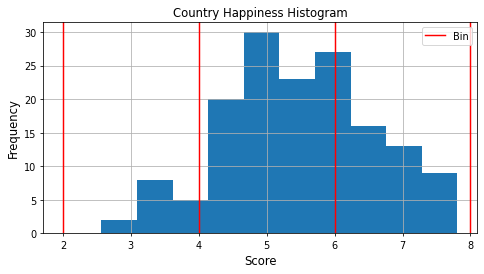

In [7]:
#We use a histogram to represent the Happiness distribution
fig, ax = plt.subplots(dpi=70, figsize=(8, 4))
world['Score'].hist()
ax.set_title('Country Happiness Histogram', fontsize=12)
ax.set_xlabel('Score', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

#We draw the bin ranges using red lines
for x in bin_ranges:
  qvl = plt.axvline(x, color='r')
ax.legend([qvl], ['Bin'], fontsize=10)
plt.show()

In [8]:
#Instead of inputting the range values for each bin, we can also automatize the process by specifying quantiles
quantile_list = [0, .25, .5, .75, 1.]
quantile_labels = ['0-25Q', '25-50Q', '50-75Q', '75-100Q']
world['Sq_range'] = pd.qcut(world['Score'], q=quantile_list) 
world['Sq_label'] = pd.qcut(world['Score'], q=quantile_list, labels=quantile_labels)

#We print the new bin quantile-based columns
world[["Country", "Score", "Sq_range", "Sq_label"]][:4]

,Country,Score,Sq_range,Sq_label
0,Finland,7.8087,"(6.228, 7.809]",75-100Q
1,Denmark,7.6456,"(6.228, 7.809]",75-100Q
2,Switzerland,7.5599,"(6.228, 7.809]",75-100Q
3,Iceland,7.5045,"(6.228, 7.809]",75-100Q


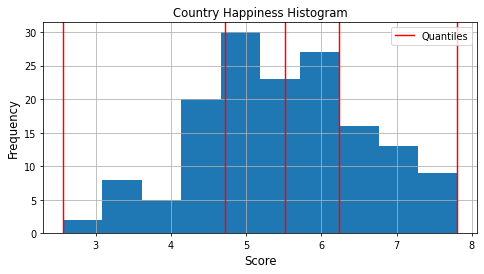

In [9]:
#We use a histogram to represent the Happiness distribution
fig, ax = plt.subplots(dpi=70, figsize=(8, 4))
world['Score'].hist()
ax.set_title('Country Happiness Histogram', fontsize=12)
ax.set_xlabel('Score', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

#We draw the quantile-based bins using red lines. Notice that each bin contains the same number of countries.
quantiles = world['Score'].quantile(quantile_list)
for x in quantiles:
  qvl = plt.axvline(x, color='r')
ax.legend([qvl], ['Quantiles'], fontsize=10)
plt.show()

### Statistical transformations

Power Transform functions help in stabilizing variance and adhering to the normal distribution.

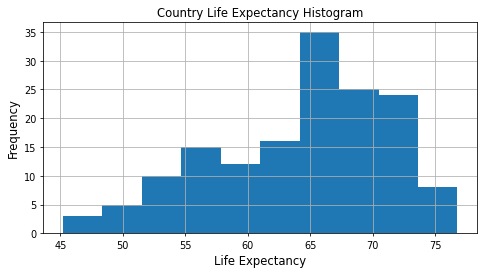

In [10]:
# We first show the distribution of life expectany using a histogram
fig, ax = plt.subplots(dpi=70, figsize=(8, 4))
world['Expectancy'].hist()
ax.set_title('Country Life Expectancy Histogram', fontsize=12)
ax.set_xlabel('Life Expectancy', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
plt.show()

In [11]:
#We use a log transform to modify the life expectancy column
world['Expectancy_log'] = np.log((world['Expectancy']))
world[["Country", "Expectancy", "Expectancy_log"]].head(5)

,Country,Expectancy,Expectancy_log
0,Finland,71.900825,4.275288
1,Denmark,72.402504,4.282241
2,Switzerland,74.102448,4.305449
3,Iceland,73.000000,4.290459
4,Norway,73.200783,4.293206


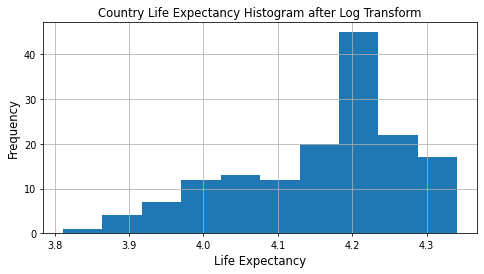

In [12]:
#We show the distribution of life expectancy after applying the log transform
fig, ax = plt.subplots(dpi=70, figsize=(8, 4))
world['Expectancy_log'].hist()
ax.set_title('Country Life Expectancy Histogram after Log Transform', fontsize=12)
ax.set_xlabel('Life Expectancy', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
plt.show()

Log transform will expand the values in the range of lower magnitudes and compress the higher values.

## Feature engineering with categorical data

In [13]:
#We create a LabelEncoder to transfrom our column region into integers
gle = LabelEncoder()
Regions = np.unique(world['Region']) 
region_labels = gle.fit_transform(world['Region'])
world["Region_label"]= region_labels

#We print the new encoded column for the region
world[["Country", "Region", "Region_label"]].head(4)

,Country,Region,Region_label
0,Finland,Western Europe,9
1,Denmark,Western Europe,9
2,Switzerland,Western Europe,9
3,Iceland,Western Europe,9


Models built using these features directly would be sub-optimal and incorrect (if there is no notion of magnitude). For nominal categories, it is preferred to use one-hot encoding instead.

In [14]:
#We create a OneHotEncoder to transform our integer region column into 10 one-hot columns.
region_ohe = OneHotEncoder()
region_feature_arr = region_ohe.fit_transform(world[["Region_label"]]).toarray()

#We create a dataframe and assign the corresponding column names
region_features = pd.DataFrame(region_feature_arr,columns=range(gle.classes_.size))

#We concatenate the "country" column with the one-hot columns
world_ohe = pd.concat([world["Country"], region_features], axis=1)
world_ohe.head(5)

,Country,0,1,2,3,4,5,6,7,8,9
0,Finland,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Denmark,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,Switzerland,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,Iceland,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,Norway,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In case the category possesses $n$ different values, we can use $n-1$ one-hot columns instead of $n$ (`drop_first`).

In [15]:
#We can also use the get_dummies function from Pandas to directly transform a column into one-hot columns.
gen_dummy_features = pd.get_dummies(world['Region_label'], drop_first=True)

#We concatenate the "country" column with the one-hot columns
pd.concat([world[['Country']], gen_dummy_features],axis=1).head(5)

,Country,1,2,3,4,5,6,7,8,9
0,Finland,0,0,0,0,0,0,0,0,1
1,Denmark,0,0,0,0,0,0,0,0,1
2,Switzerland,0,0,0,0,0,0,0,0,1
3,Iceland,0,0,0,0,0,0,0,0,1
4,Norway,0,0,0,0,0,0,0,0,1


In [16]:
#In case the memory is tight, you can also apply feature hashing
fh = FeatureHasher(n_features=6, input_type='string')
hashed_features = fh.fit_transform(world['Region'])
hashed_features = hashed_features.toarray()

#We concatenate the "country" column with the feature hashed columns
pd.concat([world[['Country', 'Region']],pd.DataFrame(hashed_features)], axis=1)[6:11]


,Country,Region,0,1,2,3,4,5
6,Sweden,Western Europe,-2.0,6.0,0.0,-1.0,1.0,0.0
7,New Zealand,North America and ANZ,-1.0,5.0,5.0,-2.0,3.0,-3.0
8,Austria,Western Europe,-2.0,6.0,0.0,-1.0,1.0,0.0
9,Luxembourg,Western Europe,-2.0,6.0,0.0,-1.0,1.0,0.0
10,Canada,North America and ANZ,-1.0,5.0,5.0,-2.0,3.0,-3.0


## Feature engineering with temporal data

In [17]:
#We create timestamps in string format and store them into a dataframe
time_stamps = ['2015-03-08 10:30:00.360000+00:00', '2017-07-13 15:45:05.755000-07:00',
               '2012-01-20 22:30:00.254000+05:30', '2016-12-25 00:30:00.000000+10:00']
df = pd.DataFrame(time_stamps, columns=['Time'])
df

,Time
0,2015-03-08 10:30:00.360000+00:00
1,2017-07-13 15:45:05.755000-07:00
2,2012-01-20 22:30:00.254000+05:30
3,2016-12-25 00:30:00.000000+10:00


In [18]:
#Using the method Timestam from Pandas, we can convert our strings into timestamp objects
ts_objs = np.array([pd.Timestamp(item) for item in np.array(df.Time)])
df['TS_obj'] = ts_objs
df

,Time,TS_obj
0,2015-03-08 10:30:00.360000+00:00,2015-03-08 10:30:00.360000+00:00
1,2017-07-13 15:45:05.755000-07:00,2017-07-13 15:45:05.755000-07:00
2,2012-01-20 22:30:00.254000+05:30,2012-01-20 22:30:00.254000+05:30
3,2016-12-25 00:30:00.000000+10:00,2016-12-25 00:30:00+10:00


In [19]:
#We can then extract date-based features
df['Year'] = df['TS_obj'].apply(lambda d: d.year)
df['Month'] = df['TS_obj'].apply(lambda d: d.month)
df['Day'] = df['TS_obj'].apply(lambda d: d.day)
df['DayOfWeek'] = df['TS_obj'].apply(lambda d: d.dayofweek)
df['DayOfYear'] = df['TS_obj'].apply(lambda d: d.dayofyear)
df['WeekOfYear'] = df['TS_obj'].apply(lambda d: d.weekofyear)

df[['Year', 'Month', 'Day', 'DayOfWeek',  'DayOfYear', 'WeekOfYear']][:3]


,Year,Month,Day,DayOfWeek,DayOfYear,WeekOfYear
0,2015,3,8,6,67,10
1,2017,7,13,3,194,28
2,2012,1,20,4,20,3


In [20]:
#We can also extract time-based features
df['Hour'] = df['TS_obj'].apply(lambda d: d.hour)
df['Minute'] = df['TS_obj'].apply(lambda d: d.minute)
df['Second'] = df['TS_obj'].apply(lambda d: d.second)
df['MUsecond'] = df['TS_obj'].apply(lambda d: d.microsecond)
df['UTC_offset'] = df['TS_obj'].apply(lambda d: d.utcoffset())

df[[ 'Hour', 'Minute', 'Second', 'MUsecond', 'UTC_offset']]

,Hour,Minute,Second,MUsecond,UTC_offset
0,10,30,0,360000,0 days 00:00:00
1,15,45,5,755000,-1 days +17:00:00
2,22,30,0,254000,0 days 05:30:00
3,0,30,0,0,0 days 10:00:00


In [21]:
#We can create custom bins
hour_bins = [-1, 5, 11, 16, 21, 23]
bin_names = ['Late Night', 'Morning', 'Afternoon', 'Evening', 'Night']
df['TimeOfDayBin'] = pd.cut(df['Hour'], bins=hour_bins, labels=bin_names)
df[['Time', 'Hour', 'TimeOfDayBin']]

,Time,Hour,TimeOfDayBin
0,2015-03-08 10:30:00.360000+00:00,10,Morning
1,2017-07-13 15:45:05.755000-07:00,15,Afternoon
2,2012-01-20 22:30:00.254000+05:30,22,Night
3,2016-12-25 00:30:00.000000+10:00,0,Late Night


## Feature engineering with image data

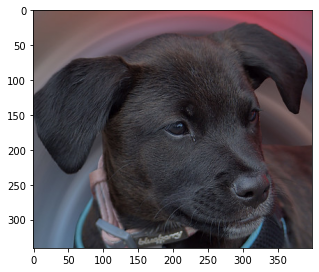

In [22]:
#Importing and ploting an image
dog = io.imread("Resources/dog.jpg")
fig = plt.figure(figsize = (5,5))
plt.imshow(dog)
plt.show()

In [23]:
#Metadata can usually be extracted from the EXIF data
f = open("Resources/dog.jpg", 'rb')
tags = exifread.process_file(f)
print(tags)

{'Image Artist': (0x013B) ASCII=SCOTT WONG @ 38, 'Image ExifOffset': (0x8769) Long=50 @ 30}


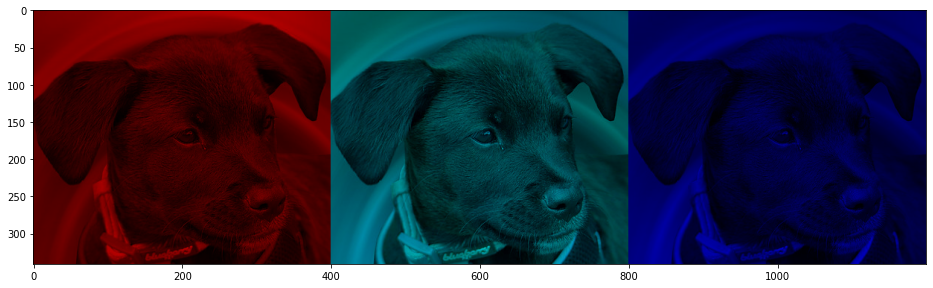

In [24]:
#We can extract each channel separately
dog_r = dog.copy() # Red Channel
dog_r[:,:,1] = dog_r[:,:,2] = 0 # set G,B pixels = 0
dog_g = dog.copy() # Green Channel
dog_g[:,:,0] = dog_r[:,:,2] = 0 # set R,B pixels = 0
dog_b = dog.copy() # Blue Channel
dog_b[:,:,0] = dog_b[:,:,1] = 0 # set R,G pixels = 0

#We concatenate each channel and plot them
plot_image = np.concatenate((dog_r, dog_g, dog_b), axis=1)
plt.figure(figsize = (16,5))
plt.imshow(plot_image)
plt.show()

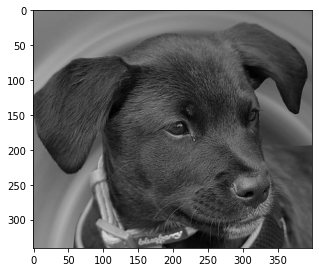

In [25]:
#We can convert a RGB picture into a grayscaled picture
dgs = rgb2gray(dog)

#We plot the resulting picture
plt.figure(figsize = (5,5))
plt.imshow(dgs, cmap='gray')
plt.show()

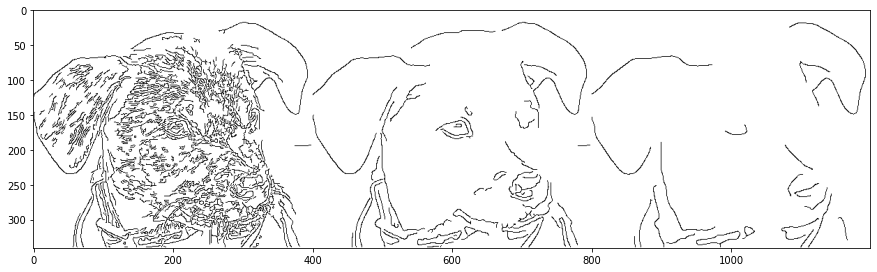

In [26]:
#To detect edges, we can use the canny filter
dog_edges_a = canny(dgs, sigma=0.8)
dog_edges_b = canny(dgs, sigma=1.7)
dog_edges_c = canny(dgs, sigma=3)

#We plot the dog with different values for the sigma parameter
fig = plt.figure(figsize = (15,5))
plt.imshow(np.concatenate((dog_edges_a,dog_edges_b,dog_edges_c), axis=1), cmap='binary')
plt.show()

The Histogram of Oriented Gradients (HOG) is an efficient way to extract features out of the pixel colors for building an object recognition classifier.

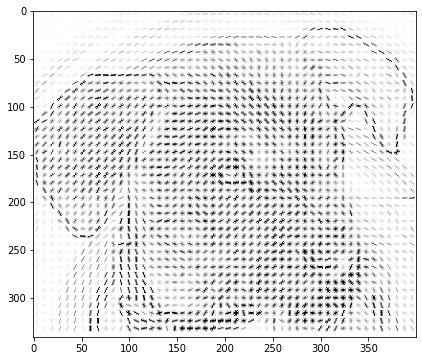

In [27]:
#We create the hog 
fd_dog, dog_hog = hog(dgs, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(3, 3), visualize=True)

# Rescale histogram for better display
dog_hogs = exposure.rescale_intensity(dog_hog, in_range=(0, 0.04))

#Drawing of the resulting HOG
fig = plt.figure(figsize = (8,6))
plt.imshow(dog_hogs, cmap='binary')
plt.show()

(720, 64)


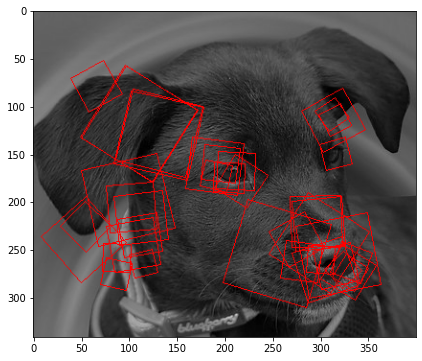

In [28]:
#We can extract localized features using surf
dog_mh = mh.colors.rgb2gray(dog)
dog_surf = surf.surf(dog_mh, nr_octaves=8, nr_scales=16,initial_step_size=1, threshold=0.1, max_points=54)
dog_surf_fds = surf.dense(dog_mh, spacing=10) 

#We obtained 720 features of size 64
print(dog_surf_fds.shape)

#We can draw coloured polygons around the interest points
fig = plt.figure(figsize = (8,6))
plt.imshow(surf.show_surf(dog_mh, dog_surf))
plt.show()

In [29]:
#We can use K-means to group similar features
k = 15
km = KMeans(k, n_init=100, max_iter=100)
km.fit(dog_surf_fds)

KMeans(max_iter=100, n_clusters=15, n_init=100)

In [30]:
#We show the number of features per cluster
labels = km.predict(dog_surf_fds)
vbow = np.bincount(labels, minlength=k)
vbow_df = pd.DataFrame(vbow) 
vbow_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,40,43,51,62,56,36,22,68,35,70,65,14,63,58,37


### Classification with VBOW

Those features can be used for classification. We show below a simple example.

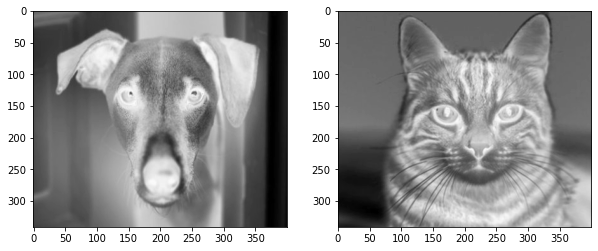

In [31]:
#For our classification example, we import two new pictures
dog2 = io.imread("Resources/dog2.jpg")
cat = io.imread("Resources/cat.png")
cat = cv2.cvtColor(cat, cv2.COLOR_BGRA2BGR)
cat = rescale(cat, 0.5, anti_aliasing=False, multichannel=True)

#We transform them into grayscale
dog2_mh = mh.colors.rgb2gray(dog2)
cat_mh  = mh.colors.rgb2gray(cat)

#We extract surf features
dog2_surf_fds = surf.dense(dog2_mh, spacing=10)
cat_surf_fds = surf.dense(cat_mh, spacing=10)

#We show the two pictures below
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1,2, 1)
ax1.imshow(dog2_mh, cmap='binary')
ax2 = fig.add_subplot(1,2, 2)
ax2.imshow(cat_mh, cmap='binary')
plt.show()

In [32]:
#We also group the features from the new dog and the cat into 15 clusters (using the same K-mean object!)
labels = km.predict(dog2_surf_fds)
new_vbow_dog = np.bincount(labels, minlength=k)
labels = km.predict(cat_surf_fds)
new_vbow_cat = np.bincount(labels, minlength=k)

#We show below the number of features per cluster
pd.concat([pd.DataFrame(["Dog", "Cat"], columns = ["Image"]),pd.DataFrame([new_vbow_dog, new_vbow_cat])], axis=1)

,Image,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,Dog,126,22,34,117,38,49,30,8,46,143,37,7,6,31,26
1,Cat,41,68,45,77,62,18,16,45,37,84,48,1,46,53,79


In [33]:
#We compute the eclidean and cosine distance between the two new pictures and our previous dog picture
eucdis = euclidean_distances(vbow.reshape((1,-1)),np.array([new_vbow_dog, new_vbow_cat]))
cossim = cosine_similarity( vbow.reshape((1,-1)), np.array([new_vbow_dog, new_vbow_cat]))

#We print the cosine similarity
pd.concat([pd.DataFrame(["Dog", "Cat"], columns = ["Image"]), pd.DataFrame({'CosineSimilarity': cossim[0]})], axis=1)

,Image,CosineSimilarity
0,Dog,0.764325
1,Cat,0.945150


As you can see, the new dog picture is closer to the previous dog picture than the cat.

# Feature Scaling

Some attributes may be completely __unbounded__ (e.g. web page hits). Raw values as input features might __make models biased__ toward features having really high magnitude values.

## Standardized scaling

The standard scaler tries to standardize each value by removing the mean and scaling the variance to be $1$. The standardized and scaled values are called z-scores.

$$SS(X) = \frac{X - \mu_X}{\sigma_X}$$ 

In [34]:
temp = pd.DataFrame([295., 25., 1700, 5.4], columns=['Temperature'])
SS = StandardScaler()
temp['zscore'] = SS.fit_transform(temp[['Temperature']])
temp

,Temperature,zscore
0,295.0,-0.302538
1,25.0,-0.689030
2,1700.0,1.708653
3,5.4,-0.717086


## Min-Max scaling

The min-max scaling transforms and scales values such that each value is within the range $[a, b]$ (which is usually $[0,1]$).

$$MMS(X) = a + \frac{X - \min(X)}{\max(X) - \min(X)} \cdot (b-a)$$

In [35]:
MMS = MinMaxScaler(feature_range = (-10,10))
temp['minmax_temp'] = MMS.fit_transform(temp[['Temperature']])
temp[["Temperature", "minmax_temp"]]

,Temperature,minmax_temp
0,295.0,-6.582084
1,25.0,-9.768677
2,1700.0,10.000000
3,5.4,-10.000000


## Robust Scaling

Contrary to the Min-Max Scaling, the robust scaling uses statistical measures to avoid being affected by outliers.

$$RS(X) = \frac{X - median(X)}{IQR_{1,3}(X)}$$

In [36]:
RS = RobustScaler()
temp['robust_temp'] = RS.fit_transform(temp[['Temperature']])
temp[["Temperature", "robust_temp"]]

,Temperature,robust_temp
0,295.0,0.215603
1,25.0,-0.215603
2,1700.0,2.459475
3,5.4,-0.246906


# Feature Selection

## Threshold-based Methods

They are filter-based feature selection strategies, which use some form of threshold to limit the number of features.

In [37]:
#Recall the 10 one-hot columns representing to the region of each country
world_ohe.head(3)

,Country,0,1,2,3,4,5,6,7,8,9
0,Finland,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Denmark,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,Switzerland,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [38]:
#We fit out variance theshold on the 10 one-hot columns
vt = VarianceThreshold(threshold=.05)
vt.fit(world_ohe.iloc[:, 1:11])

# We show the variance for each column. Columns with low variance will be removed
pd.DataFrame({'var': np.round(vt.variances_,2),'select?': vt.get_support()},index=[world_ohe.iloc[:, 1:11].columns]).T

,0,1,2,3,4,5,6,7,8,9
var,0.1,0.07,0.04,0.12,0.1,0.03,0.04,0.06,0.19,0.12
select?,True,True,False,True,True,False,False,True,True,True


## Statistical Methods

They are filter-based feature selection methods, which select features based on univariate statistical tests.

In [39]:
#We import scikit-learn's breast cancer dataset
bc_data = load_breast_cancer()

#We separate features and the target variable
bc_features = pd.DataFrame(bc_data.data, columns=bc_data.feature_names)
bc_classes = pd.DataFrame(bc_data.target, columns=['IsMalignant'])
#We convert them into Numpy arrays
bc_X = np.array(bc_features)
bc_y = np.array(bc_classes).T[0]

#We use SelectKBest to score the features w.r.t. the chi2 scoring function
skb = SelectKBest(score_func=chi2, k=10)
skb.fit(bc_X, bc_y)
feature_scores = [(item, score) for item, score in zip(bc_data.feature_names, skb.scores_)]
pd.DataFrame(sorted(feature_scores, key=lambda x: -x[1]), columns=["Feature_name", "Score"])

,Feature_name,Score
0,worst area,112598.431564
1,mean area,53991.655924
2,area error,8758.504705
3,worst perimeter,3665.035416
4,mean perimeter,2011.102864
5,worst radius,491.689157
6,mean radius,266.104917
7,perimeter error,250.571896
8,worst texture,174.449400
9,mean texture,93.897508


We can then restrict ourselves to the $n$ best features.

In [40]:
#We restrict ourselves to the best 10 features
feature_names_kbest = bc_data.feature_names[skb.get_support()]
feature_subset_df = bc_features[feature_names_kbest]
bc_SX = np.array(feature_subset_df)
np.round(feature_subset_df.head(3), 2)

,mean radius,mean texture,mean perimeter,mean area,perimeter error,area error,worst radius,worst texture,worst perimeter,worst area
0,17.99,10.38,122.8,1001.0,8.59,153.40,25.38,17.33,184.6,2019.0
1,20.57,17.77,132.9,1326.0,3.40,74.08,24.99,23.41,158.8,1956.0
2,19.69,21.25,130.0,1203.0,4.58,94.03,23.57,25.53,152.5,1709.0


How does our model performs with this restricted set of features?

In [41]:
#We build a logistic regression model
lr = LogisticRegression(max_iter=5000)

#We evaluate the accuracy of the model trained on the full feature set
full_feat_acc = np.average(cross_val_score(lr, bc_X, bc_y, scoring='accuracy', cv=5))
print('Model accuracy with complete feature set', bc_X.shape, ':', full_feat_acc)

#We evaluate the accuracy of the model trained on only the 10 best features
sel_feat_acc = np.average(cross_val_score(lr, bc_SX, bc_y, scoring='accuracy', cv=5))
print('Model accuracy with selected feature set', bc_SX.shape, ':', sel_feat_acc)

Model accuracy with complete feature set (569, 30) : 0.9525694767893184
Model accuracy with selected feature set (569, 10) : 0.947290793355069


## Recursive Feature Elimination (RFE)

RFE is a wrapper-based feature selection technique, which ranks features using ML estimators such that lower scored features are recursively eliminated.


In [42]:
#We create a RFE with a logistic regression model as the estimator to select the best 5 features
rfe = RFE(estimator=lr, n_features_to_select=5, step=1)
rfe.fit(bc_X, bc_y)

#We obtain the new dataset with the 5 best features
feature_names_kbest = bc_data.feature_names[rfe.get_support()]
feature_subset_df_RFE = bc_features[feature_names_kbest]

#We evaluate the accuracy of the model trained on only the 5 best features
print('Model accuracy with selected feature set', np.array(feature_subset_df_RFE).shape, ':', np.average(cross_val_score(lr, np.array(feature_subset_df_RFE), bc_y, scoring='accuracy', cv=5)))

Model accuracy with selected feature set (569, 5) : 0.9508306163639186


As you can notice, it is false that the greater the number of features, the higher the performance.

## Model-based Selection

Tree based models can also be used for feature selection as they also compute feature scores when building the model. 

In [43]:
#By using the random forest classifier, we can obtain importance scores for each feature
rfc = RandomForestClassifier()
rfc.fit(bc_X, bc_y)
importance_scores = rfc.feature_importances_

#We show the best features w.r.t. their importance
feature_importances = [(feature, score) for feature, score in zip(bc_data.feature_names, importance_scores)]
pd.DataFrame(sorted(feature_importances, key=lambda x: -x[1])[:5], columns=["Feature_name", "Score"])

,Feature_name,Score
0,worst perimeter,0.153498
1,worst area,0.150142
2,worst concave points,0.123505
3,worst radius,0.093189
4,mean concavity,0.082459


# Feature Extraction

## Dimension Reduction with PCA (1)

### PCA Example

Let us consider the following data $M$ about 3-dimensional points. We want to reduce it to only 2 features using PCA.


In [44]:
#We create the example's Numpy array
M1 = np.array([[3,2,-2],[4,3,-3],[1,1,0],[5,4,-1],[2,1,-0.5],[-2,-4,3],[-4,-1,1],[-1,-1,3],[0.5,-1,1],[-2,-2.5,1.5]])
PCA_example_raw = pd.DataFrame(M1, columns= ["X","Y","Z"])
PCA_example_raw["type"] = 0
PCA_example_raw.loc[PCA_example_raw.X > 0, "type"] = 1
PCA_example_raw

,X,Y,Z,type
0,3.0,2.0,-2.0,1
1,4.0,3.0,-3.0,1
2,1.0,1.0,0.0,1
3,5.0,4.0,-1.0,1
4,2.0,1.0,-0.5,1
5,-2.0,-4.0,3.0,0
6,-4.0,-1.0,1.0,0
7,-1.0,-1.0,3.0,0
8,0.5,-1.0,1.0,1
9,-2.0,-2.5,1.5,0


The first step is to adjust the data $M$ so that the mean of each column is zero. The new data is denoted by $M'$

In [45]:
M2 = M1 - np.mean(M1,0)
pd.DataFrame(M2, columns= ["X - mean(X)","Y - mean(Y)","Z - mean(Z)"])


,X - mean(X),Y - mean(Y),Z - mean(Z)
0,2.35,1.85,-2.3
1,3.35,2.85,-3.3
2,0.35,0.85,-0.3
3,4.35,3.85,-1.3
4,1.35,0.85,-0.8
5,-2.65,-4.15,2.7
6,-4.65,-1.15,0.7
7,-1.65,-1.15,2.7
8,-0.15,-1.15,0.7
9,-2.65,-2.65,1.2


The second step consists in computing the covariance matrix of $M'$. We recall that:

$$cov(X,Y) = \frac{\sum\limits_{i=1}^{n} (x_i - \mu_X)(y_i - \mu_Y)}{n-1}$$

In [46]:
#Numpy has a function to compute the covariance matrix directly
C = np.cov(np.transpose(M2),bias=True)
pdC = pd.DataFrame(C, columns= ["cov(_,X')","cov(_,Y')","cov(_,Z')"])
labels = pd.DataFrame(["cov(X',_)", "cov(Y',_)", "cov(Z',_)"], columns = ["."])
pd.concat([labels, pdC], axis=1)

,.,"cov(_,X')","cov(_,Y')","cov(_,Z')"
0,"cov(X',_)",7.6025,5.7525,-4.145
1,"cov(Y',_)",5.7525,5.6025,-3.870
2,"cov(Z',_)",-4.1450,-3.8700,3.560


In the third step, we need to computing the eigenvectors of the covariance matrix. Here there are 3 eigenvectors, sorted by decreasing eigenvalues.

In [47]:
EigVec = np.linalg.eig(C)
print(EigVec[1])

[[ 0.68230374  0.68709062 -0.24973605]
 [ 0.58555231 -0.30909156  0.74939369]
 [-0.43771007  0.65754764  0.61322182]]


Since we want to reduce the dimenion to $2$, we select the best $2$ eigenvectors. This will be our matrix $F$.

In [48]:
selec_vectors = np.delete(EigVec[1], obj = 2, axis= 1)
print(selec_vectors)

[[ 0.68230374  0.68709062]
 [ 0.58555231 -0.30909156]
 [-0.43771007  0.65754764]]


The last step consists in computing the dot product of $F^T$ with $M'$. The resulting data only has two features C1 and C2.

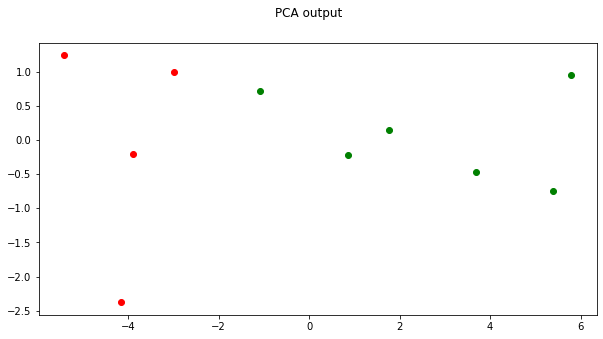

In [49]:
M3 =  np.dot(np.transpose(selec_vectors),np.transpose(M2))
M4 = pd.concat([pd.DataFrame(np.transpose(M3), columns=["C1", "C2"]), PCA_example_raw.type], axis=1)

#We can now represent our dataset in 2D
x1 = M4[M4.type == 1]["C1"]
y1 = M4[M4.type == 1]["C2"]
x2 = M4[M4.type == 0]["C1"]
y2 = M4[M4.type == 0]["C2"]

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(np.array(x1), np.array(y1), 'o', color='green')
ax.plot(np.array(x2), np.array(y2), 'o', color='red')
fig.suptitle('PCA output')
plt.show()

In [50]:
#The Scikit-learn library provides an easy access to PCA.
pca = PCA(n_components=2)
pca.fit_transform(M1)

array([[ 3.69341871,  0.469516  ],
       [ 5.39898482,  0.74906458],
       [ 0.86783879,  0.2195104 ],
       [ 5.79142074, -0.94402975],
       [ 1.76899756, -0.1388064 ],
       [-5.41996417, -1.23731845],
       [-4.15249458,  2.37923272],
       [-2.9810035 , -0.9971344 ],
       [-1.08212776, -0.71267504],
       [-3.88507061,  0.21264034]])